for Swati-san's microglia data, and practice for MicrogliaTrackingGUI development

In [1]:
import sys
import os

dir_notebook = os.path.dirname(os.path.abspath("__file__"))
dir_parent = os.path.dirname(dir_notebook)
if not dir_parent in sys.path:
    sys.path.append(dir_parent)

from PyQt5.QtWidgets import QMainWindow, QWidget, QGridLayout, QVBoxLayout, QHBoxLayout, QApplication
from optic.config import *
from optic.controls import *
from optic.dialog import *
from optic.gui import *
from optic.io import *
from optic.manager import *
from optic.gui.bind_func import *

class TIFStackExplorerGUI(QMainWindow):
    def __init__(self):
        APP_NAME = "TIFSTACK_EXPLORER"
        QMainWindow.__init__(self)
        self.widget_manager, self.config_manager, self.data_manager, self.control_manager, self.layout_manager = initManagers(
            WidgetManager(), ConfigManager(), DataManager(), ControlManager(), LayoutManager()
        )
        self.config_manager.setCurrentApp(APP_NAME)
        self.app_keys = self.config_manager.gui_defaults["APP_KEYS"]
        self.app_key_pri = self.app_keys[0]

        self.setupUI_done = False
        setupMainWindow(self, self.config_manager.gui_defaults)

        self.initUI()

    """
    setup UI Function
    """
    def initUI(self):
        self.central_widget = QWidget(self)
        self.setCentralWidget(self.central_widget)
        self.layout_main = QGridLayout(self.central_widget)

        # layout for file load
        self.layout_file_load = QVBoxLayout()
        self.setupFileLoadUI()
        self.layout_main.addLayout(self.layout_file_load, 1, 0, 1, 1)

        # layout for main UI
        self.layout_main_ui = QGridLayout()
        self.layout_main.addLayout(self.layout_main_ui, 0, 0, 1, 1)

    def setupFileLoadUI(self):
        file_load_widget = QWidget()
        layout = QVBoxLayout(file_load_widget)
        layout.addLayout(self.makeLayoutSectionBottom())
        # bindFunc
        self.bindFuncFileLoadUI()

        self.layout_file_load.addWidget(file_load_widget)

    def loadFilePathsandInitialize(self):
        self.control_manager, self.data_manager = initManagers(self.control_manager, self.data_manager)
        success = self.loadData()
        if success:
            QMessageBox.information(self, "File load", "File loaded successfully!")
            self.setupMainUI()
            self.control_manager.view_controls[self.app_key_pri].updateView()
        else:
            QMessageBox.warning(self, "File Load Error", "Failed to load the file.")
            return

    def setupMainUI(self):
        if self.setupUI_done:
            clearLayout(self.layout_main_ui)
        
        self.setupMainUILayouts()
        self.setupControls()
        self.bindFuncAllWidget()

        self.setupUI_done = True

    def loadData(self):
        success = self.data_manager.loadTiffStack(
            app_key=self.app_key_pri,
            path_tiff=self.widget_manager.dict_lineedit[f"{self.app_key_pri}_path_tiff"].text(),
            )
        return success

    def setupMainUILayouts(self):
        self.layout_main_ui.addLayout(self.makeLayoutSectionLeftUpper(), 0, 0)
        self.layout_main_ui.addLayout(self.makeLayoutSectionRightUpper(), 0, 1)

    def setupControls(self):
        self.control_manager.view_controls[self.app_key_pri] = ViewControl(
            app_key=self.app_key_pri,
            q_view=self.widget_manager.dict_view[self.app_key_pri], 
            q_scene=self.widget_manager.dict_scene[self.app_key_pri], 
            data_manager=self.data_manager, 
            widget_manager=self.widget_manager,
            config_manager=self.config_manager,
            control_manager=self.control_manager,
        )
        # self.control_manager.view_controls[self.app_key_pri].setViewSize()

    """
    makeLayout Function; Component
    return -> Layout
    """
    "Upper Left"
    # XYZCT tiff stack view, slider
    def makeLayoutComponentImageView(self):
        layout = makeLayoutViewWithZTSlider(
            self.widget_manager, 
            self.app_key_pri,
            slider_z=True,
            slider_t=True,
            key_label_z=f"{self.app_key_pri}_plane_z",
            key_label_t=f"{self.app_key_pri}_plane_t",
            key_slider_z=f"{self.app_key_pri}_plane_z",
            key_slider_t=f"{self.app_key_pri}_plane_t",
            stack_size_z=self.data_manager.getSizeOfZ(self.app_key_pri),
            stack_size_t=self.data_manager.getSizeOfT(self.app_key_pri),
            )
        return layout
    
    # channel contrast, ROI opacity slider
    def makeLayoutComponentContrastSlider(self):
        layout = QVBoxLayout()
        channels = self.config_manager.gui_defaults["CHANNELS"]
        layout_channel = QHBoxLayout()
        for channel in channels:
            layout_channel.addLayout(makeLayoutContrastSlider(
                self.widget_manager, 
                key_label=f"{self.app_key_pri}_{channel}", 
                key_checkbox=f"{self.app_key_pri}_{channel}", 
                key_slider=f"{self.app_key_pri}_{channel}", 
                label_checkbox=f"Show {channel} channel", 
                label_label=f"{channel} Value", 
                checked=True
            ))
        layout.addLayout(layout_channel)
        return layout

    "Upper Right"
    def makeLayoutComponentStackRegistration(self):
        layout = makeLayoutStackRegistration(
            self.widget_manager,
            self.data_manager,
            self.app_key_pri,                 
            f"elastix_registration",
            f"elastix_ref_c",
            f"elastix_ref_plane_t",
            f"elastix_ref_plane_z",
            f"elastix_method",
            f"elastix_ref_c",
            f"elastix_ref_plane_t",       
            f"elastix_ref_plane_z",        
            f"elastix_config", 
            f"elastix_run_t",   
            f"elastix_run_z",    
            f"export_reg_tiff",
            f"show_reg_result"
        )
        layout.addLayout(makeLayoutSaveElastixTransform(
            self.widget_manager,
            key_button=f"elastix_save_transform",
        ))
        layout.addLayout(makeLayoutApplyElastixTransform(
            self.widget_manager,
            key_label="elastix_apply_transform",
            key_button_xyct_xyczt=f"elastix_apply_transform_xyct_xyczt",
        ))
        return layout
    
    # def makeLayoutComponentStackNormalization(self):
    #     layout = makeLayoutStackNormalization(
    #         self.widget_manager,
    #         key_label=f"{self.app_key_pri}_normalization",
    #         key_label_area=f"{self.app_key_pri}_normalization_area",
    #         key_lineedit_area=f"{self.app_key_pri}_normalization_area",
    #         key_button_area=f"{self.app_key_pri}_normalization_area_set",
    #         key_button_add=f"{self.app_key_pri}_normalization_area_add",
    #         key_button_remove=f"{self.app_key_pri}_normalization_area_remove",
    #         key_button_clear=f"{self.app_key_pri}_normalization_area_clear",
    #         key_button_run=f"{self.app_key_pri}_normalization_run",
    #         key_listwidget=f"{self.app_key_pri}_normalization_area",
    #     )
    #     return layout

    def makeLayoutComponentExportFallLike(self):
        layout = makeLayoutExportFallLike(
            self.widget_manager,
            key_label="export_fall_like",
            key_button_load_mask="load_cellpose_mask",
            key_button_export="export_fall_like",
        )
        return layout

    "Bottom"
    def makeLayoutComponentFileLoadUI(self):
        layout = QVBoxLayout()

        # LineEdit
        list_label = ["Microglia tiff image file path"]
        list_key = [f"{self.app_key_pri}_path_tiff"]
        for label, key in zip(list_label, list_key):
            layout.addLayout(makeLayoutLoadFileWidget(
                self.widget_manager, 
                label=label, 
                key_label=key, 
                key_lineedit=key, 
                key_button=key
            ))
        # Button
        layout.addLayout(makeLayoutLoadFileExitHelp(self.widget_manager))
        return layout

    """
    makeLayout Function; Section

    """
    def makeLayoutSectionLeftUpper(self):
        layout = QVBoxLayout()
        layout.addLayout(self.makeLayoutComponentImageView())
        layout.addLayout(self.makeLayoutComponentContrastSlider())
        return layout
    
    def makeLayoutSectionRightUpper(self):
        layout = QVBoxLayout()
        layout.addLayout(self.makeLayoutComponentStackRegistration())
        # layout.addLayout(self.makeLayoutComponentStackNormalization())
        layout.addLayout(self.makeLayoutComponentExportFallLike())
        return layout

    def makeLayoutSectionBottom(self):
        layout = self.makeLayoutComponentFileLoadUI()
        return layout
    
    """
    make SubWindow, Dialog Function
    """
    def showSubWindowElastixParamsConfig(self):
        config_window = ElastixParamsConfigDialog(
            self, 
            self.config_manager.json_config.get("elastix_params"),
            self.config_manager.gui_defaults,
        )
        if config_window.exec_() == QDialog.Accepted:
            self.config_manager.json_config.set("elastix_params", config_window.elastix_params)

    """
    bindFunc Function
    """
    def bindFuncFileLoadUI(self):        
        list_key = [f"{self.app_key_pri}_path_tiff"]
        list_filetype = [Extension.TIFF]
        for key, filetype in zip(list_key, list_filetype):
            bindFuncLoadFileWidget(
                q_widget=self, 
                q_button=self.widget_manager.dict_button[key], 
                q_lineedit=self.widget_manager.dict_lineedit[key], 
                filetype=filetype
            )

        self.widget_manager.dict_button["load_file"].clicked.connect(lambda: self.loadFilePathsandInitialize())
        bindFuncExit(q_window=self, q_button=self.widget_manager.dict_button["exit"])
        bindFuncHelp(q_button=self.widget_manager.dict_button["help"], url=AccessURL.HELP[self.config_manager.current_app])

    def bindFuncAllWidget(self):
        # Z,T plane slider
        bindFuncPlaneZSlider(self.widget_manager.dict_slider[f"{self.app_key_pri}_plane_z"], self.control_manager.view_controls[self.app_key_pri])
        bindFuncPlaneTSlider(self.widget_manager.dict_slider[f"{self.app_key_pri}_plane_t"], self.control_manager.view_controls[self.app_key_pri])
        
        # Slider Contrast valueChanged, Checkbox show channel stateChanged
        for channel in self.config_manager.gui_defaults["CHANNELS"]:
            bindFuncBackgroundContrastSlider(
                q_slider_min=self.widget_manager.dict_slider[f"{self.app_key_pri}_{channel}_contrast_min"],
                q_slider_max=self.widget_manager.dict_slider[f"{self.app_key_pri}_{channel}_contrast_max"],
                view_control=self.control_manager.view_controls[self.app_key_pri],
                channel=channel
            )
            bindFuncBackgroundVisibilityCheckbox(
                q_checkbox=self.widget_manager.dict_checkbox[f"{self.app_key_pri}_{channel}_show"], 
                view_control=self.control_manager.view_controls[self.app_key_pri],
                channel=channel,
            )
        # View Events
        bindFuncViewEvents(
            q_view=self.widget_manager.dict_view[self.app_key_pri],
            view_control=self.control_manager.view_controls[self.app_key_pri],
        )

        # # set rectangle range and draw rectangle
        # bindFuncButtonSetRectangeRange(
        #     q_widget=self,
        #     q_button=self.widget_manager.dict_button[f"{self.app_key_pri}_normalization_area_set"],
        #     q_lineedit=self.widget_manager.dict_lineedit[f"{self.app_key_pri}_normalization_area"],
        #     view_control=self.control_manager.view_controls[self.app_key_pri]
        # ) 
        # # add, remove, clear rectangle range
        # bindFuncButtonManageRectangleRangeForListWidget(
        #     q_widget=self,
        #     q_button_add=self.widget_manager.dict_button[f"{self.app_key_pri}_normalization_area_add"],
        #     q_button_remove=self.widget_manager.dict_button[f"{self.app_key_pri}_normalization_area_remove"],
        #     q_button_clear=self.widget_manager.dict_button[f"{self.app_key_pri}_normalization_area_clear"],
        #     q_listwidget=self.widget_manager.dict_listwidget[f"{self.app_key_pri}_normalization_area"],
        #     q_lineedit=self.widget_manager.dict_lineedit[f"{self.app_key_pri}_normalization_area"],
        #     view_control=self.control_manager.view_controls[self.app_key_pri]
        # )
        # # highlight rectangle with selected listwidget item
        # bindFuncListWidgetSelectionChanged(
        #     q_listwidget=self.widget_manager.dict_listwidget[f"{self.app_key_pri}_normalization_area"],
        #     view_control=self.control_manager.view_controls[self.app_key_pri]
        # )
        # # run normalization
        # bindFuncButtonRunImageNormalization(
        #     q_widget=self,
        #     q_button=self.widget_manager.dict_button[f"{self.app_key_pri}_normalization_run"],
        #     q_lineedit=self.widget_manager.dict_lineedit[f"{self.app_key_pri}_path_tiff"],
        #     q_listwidget=self.widget_manager.dict_listwidget[f"{self.app_key_pri}_normalization_area"],
        #     tiff_stack=self.data_manager.getTiffStack(self.app_key_pri),
        #     metadata=self.data_manager.getTiffMetadata(self.app_key_pri),
        # )
        # Elastix config
        self.widget_manager.dict_button[f"elastix_config"].clicked.connect(
            lambda: self.showSubWindowElastixParamsConfig()
        )
        # show registration result
        bindFuncCheckboxShowRegisteredStack(
            q_checkbox=self.widget_manager.dict_checkbox[f"show_reg_result"],
            view_control=self.control_manager.view_controls[self.app_key_pri]
        )
        # run Elastix registration t-axis
        bindFuncButtonRunElastixForSingleStack(
                self,
                q_button=self.widget_manager.dict_button[f"elastix_run_t"],
                data_manager=self.data_manager,
                config_manager=self.config_manager,
                app_key=self.app_key_pri,
                combobox_elastix_method=self.widget_manager.dict_combobox[f"elastix_method"],
                combobox_channel_ref=self.widget_manager.dict_combobox[f"elastix_ref_c"],
                combobox_idx_ref=self.widget_manager.dict_combobox[f"elastix_ref_plane_t"],
                axis="t"
        )
        # run Elastix registration z-axis
        bindFuncButtonRunElastixForSingleStack(
                self,
                q_button=self.widget_manager.dict_button[f"elastix_run_z"],
                data_manager=self.data_manager,
                config_manager=self.config_manager,
                app_key=self.app_key_pri,
                combobox_elastix_method=self.widget_manager.dict_combobox[f"elastix_method"],
                combobox_channel_ref=self.widget_manager.dict_combobox[f"elastix_ref_c"],
                combobox_idx_ref=self.widget_manager.dict_combobox[f"elastix_ref_plane_t"],
                axis="z"
        )
        # export registration result
        bindFuncButtonSaveRegisterdImage(
            q_widget=self,
            q_button=self.widget_manager.dict_button[f"export_reg_tiff"],
            data_manager=self.data_manager,
            app_key=self.app_key_pri,
            path_tif_src=self.widget_manager.dict_lineedit[f"{self.app_key_pri}_path_tiff"].text(),
        )
        # save transform parameters
        bindFuncButtonSaveElastixTransform(
            q_widget=self,
            q_button=self.widget_manager.dict_button[f"elastix_save_transform"],
            q_linnedit=self.widget_manager.dict_lineedit[f"{self.app_key_pri}_path_tiff"],
            data_manager=self.data_manager,
            app_key=self.app_key_pri,
            gui_defaults=self.config_manager.gui_defaults
        )
        # apply transform parameters from XYCT to XYCZT
        bindFuncButtonApplyElastixTransform_XYCTtoXYCZT(
            q_widget=self,
            q_button=self.widget_manager.dict_button[f"elastix_apply_transform_xyct_xyczt"],
            data_manager=self.data_manager,
            app_key=self.app_key_pri,
        )
        # load cellpose mask (XY)
        bindFuncButtonLoadCellposeMask(
            q_window=self,
            q_button=self.widget_manager.dict_button[f"load_cellpose_mask"],
            data_manager=self.data_manager,
            app_key=self.app_key_pri,
        )


if __name__ == "__main__":
    app = QApplication(sys.argv) if QApplication.instance() is None else QApplication.instance()
    applyAppStyle(app)
    gui = TIFStackExplorerGUI()
    gui.show()
    sys.exit(app.exec_())

SystemExit: 0

To exit: use 'exit', 'quit', or Ctrl-D.


In [29]:
path_Fall = "D:/optic/data/Fall_KA86-f1-z160_240227_1-preHolo.mat"

Fall = loadmat(path_Fall, simplify_cells=False)
Fall.keys()

dict_keys(['__header__', '__version__', '__globals__', 'stat', 'ops', 'F', 'Fneu', 'spks', 'iscell', 'redcell', 'F_chan2', 'Fneu_chan2'])

In [30]:
from optic.preprocessing.preprocessing_fall import convertMatToDictFall

convertMatToDictFall(Fall)

{'stat': {0: {'ypix': array([213, 213, 214, 214, 214, 214, 214, 214, 214, 214, 214, 215, 215,
          215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 216, 216,
          216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216,
          216, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217,
          217, 217, 217, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218,
          218, 218, 218, 218, 219, 219, 219, 219, 219, 219, 219, 219, 219,
          219, 219, 219, 219, 220, 220, 220, 220, 220, 220, 220, 220, 220,
          220, 220, 220, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221,
          221, 221, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222,
          223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 224, 224, 224,
          224, 224, 224, 224, 224, 225, 225, 225, 225, 225, 225, 226, 226,
          226, 226, 227]),
   'xpix': array([361, 362, 361, 362, 363, 371, 372, 373, 374, 375, 376, 361, 362,
          363, 364, 365, 370, 371, 372, 373, 3

In [ ]:
# concatenate bg_image and dict_roi_coords and export as FallLike.mat

dict_roi_coords = gui.data_manager.getDictROICoords("pri")
img_bg = gui.data_manager.getTiffStack("pri")[:, :, 0, 0, 0]

Falllike = {
    "stat": {},
    "ops": {},
    "F": np.array([]),
    "Fneu": np.array([]),
    "spks": np.array([]),
    "iscell": np.array([]),
    "redcell": np.array([]),
    "F_chan2": np.array([]),
    "Fneu_chan2": np.array([]),
    "spks_chan2": np.array([]),
}

nROIs = len(dict_roi_coords)

Falllike["iscell"] = np.zeros((nROIs, 2))
Falllike["stat"] = [v for v in dict_roi_coords.values()]

In [18]:
np.zeros((nROIs, 2))

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.

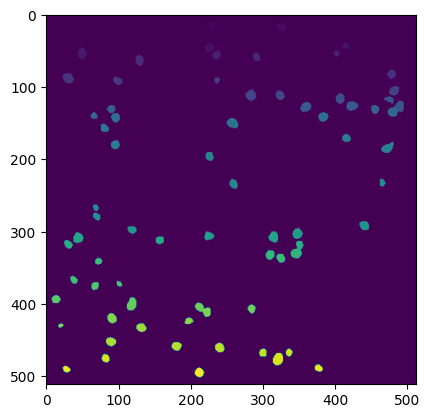

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

path_npy = "D:/optic/data/from_Tanisumi/241219-MaskedData/IMGsnap_XXX_seg.npy"
path_mat = "D:/optic/data/from_Tanisumi/241219-MaskedData/Masks_XXX.mat"

mask_npy = np.load(path_npy, allow_pickle=True).tolist()
mask_mat = loadmat(path_mat, simplify_cells=True)

mask_mat

plt.imshow(mask_mat["DATA"])